## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [149]:
!pwd

/home/ubuntu/work/SAM_demo0


In [150]:
!nvidia-smi

Sun Apr 16 13:54:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   35C    P0    50W / 300W |   7440MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Segment Anything Model (SAM) and other dependencies

In [151]:
import sys

!pip install -r requirements.txt
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-k7ulyuo9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-k7ulyuo9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done


# download dataset from Google Drive

In [152]:
import gdown
import zipfile
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import supervision as sv

Dataset_name = "Egg"
Dataset_name = "Can"


if Dataset_name == "Egg":
    # # same as the above, but with the file ID
     id = "1V-Lr_FQaysX9tlu29MQAQkeBIveDhiC6"
     zip_output = "Egg_Dataset.zip"
else :
    # same as the above, but with the file ID
    id = "1-AQSLwoycnOMruAeTXA7zGt92mfvRyk0"
    zip_output = "Can_Dataset.zip"

    

# Download the file from `url` and save it locally 
if not os.path.isdir( zip_output.split(".")[0] ):
    gdown.download(id=id, output= zip_output, quiet=False)
    with zipfile.ZipFile(zip_output, 'r') as zip_ref:
        zip_ref.extractall('.')
    
    # delete zip file
    os.remove(zip_output)    

## Find Image Files

In [153]:

def find_jpg_files(folder_path):
    jpg_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith(".jpeg"):
                jpg_files.append(os.path.join(root, file))
    return jpg_files



jpg_files           = find_jpg_files(zip_output.split(".")[0])

print("files = ", len(jpg_files),'\n')

jpg_files[0:5]

files =  510 



['Can_Dataset/1/anormal/down/IMG_0686.jpeg',
 'Can_Dataset/1/anormal/down/IMG_0727.jpeg',
 'Can_Dataset/1/anormal/down/IMG_0696.jpeg',
 'Can_Dataset/1/anormal/down/IMG_0690.jpeg',
 'Can_Dataset/1/anormal/down/IMG_0756.jpeg']

### Download SAM weights

In [154]:
if not os.path.isdir("weights") :
    os.mkdir("weights")

if not os.path.isfile("./weights/sam_vit_h_4b8939.pth") :
   !wget -q -P ./weights https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  

## Load Model (Take a Minutes)

In [155]:
%%time
import torch
from  segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

torch.cuda.empty_cache()

DEVICE     = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


if 'sam' in globals() or 'variable_name' in locals():
    # sam is defined
    print("Sam is already define")
else:
    sam            = sam_model_registry["vit_h"](checkpoint="./weights/sam_vit_h_4b8939.pth").to(device=DEVICE)
   


print(f"Device = {DEVICE} with Memory = ",torch.cuda.memory_allocated() / 1024 ** 2, "MB")

Sam is already define
Device = cuda:0 with Memory =  2517.70556640625 MB
CPU times: user 8 µs, sys: 24.2 ms, total: 24.2 ms
Wall time: 24 ms


In [156]:
mask_generator = SamAutomaticMaskGenerator(model=sam,points_per_side=8)
                                           




# Radom single image to test model

Text(0.5, 1.0, 'IMG_0750.jpeg')

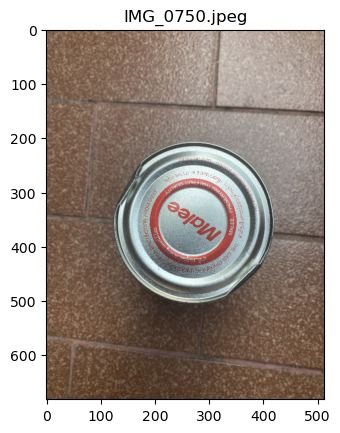

In [157]:
def GetImage(path, new_w = 512):
    
    image_bgr  = cv2.imread(IMAGE_PATH)
    # Get the current height and width of the image
    h, w = image_bgr.shape[:2]
    # Calculate the new height with the same aspect ratio
    new_w = min(w,new_w)
    ratio = new_w / w
    image_bgr = cv2.resize(image_bgr , (int(new_w), int(int(h * ratio))))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    return image_rgb 



IMAGE_PATH = random.sample(jpg_files, 1)[0] 
image_rgb = GetImage(IMAGE_PATH , new_w = 512)

   
plt.imshow(image_rgb)
plt.title(IMAGE_PATH.split('/')[-1])




### 1. Run SAM

In [158]:
%time
# Clear CUDA memory
torch.cuda.empty_cache()
sam_result = mask_generator.generate(image_rgb)

print(len(sam_result))
print(sam_result[0].keys())

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs
16
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### 2. Preview masks with SAM

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

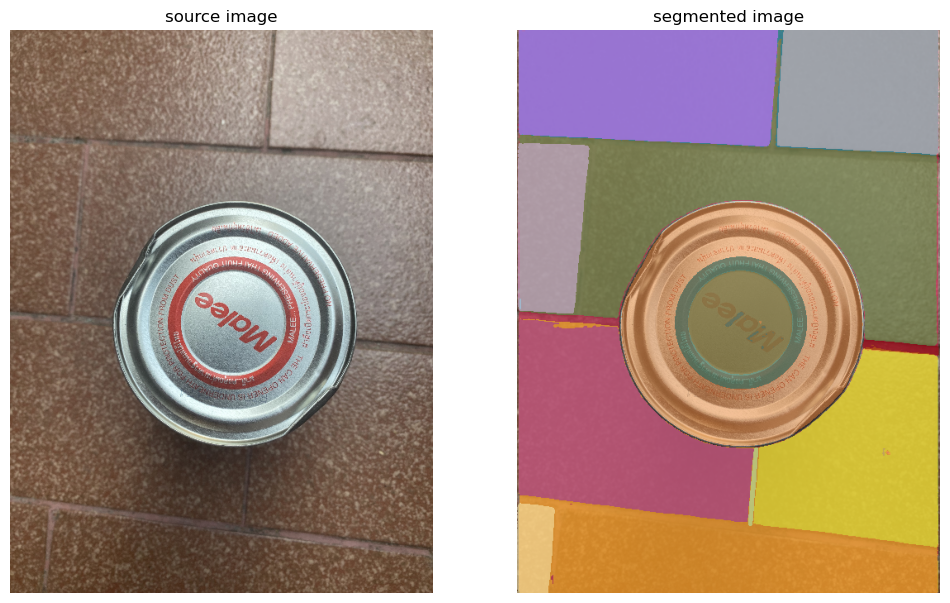

CPU times: user 834 ms, sys: 136 ms, total: 971 ms
Wall time: 709 ms


In [159]:
%%time

def SAM_Image_Compare(sam_result, image_rgb):
   
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR) 
    mask_annotator = sv.MaskAnnotator()
    detections = sv.Detections.from_sam(sam_result=sam_result)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        size=(12, 12),
        titles=['source image', 'segmented image']
    )

    
SAM_Image_Compare(sam_result, image_rgb)

### 3. Separate Mask

In [160]:
masks     = [ mask['segmentation'].astype(np.uint8) * 255 for mask  in sorted(sam_result, key=lambda x: x['area'], reverse=True) ]
bboxs     = [ mask['bbox'] for mask  in sorted(sam_result, key=lambda x: x['area'], reverse=True) ]
segments  =  [ cv2.bitwise_and(image_rgb, image_rgb, mask=img_binary) for img_binary in  masks]


print(len(masks), len(bboxs) , len(segments))

16 16 16


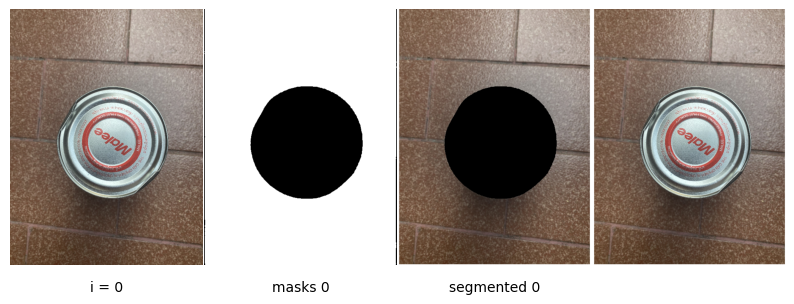

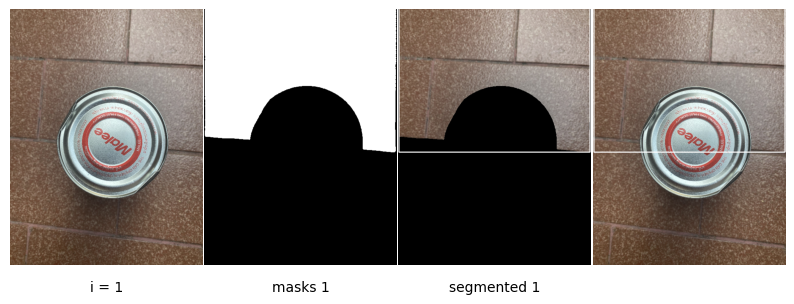

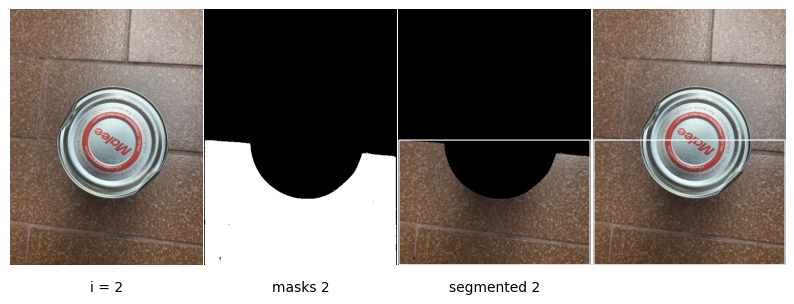

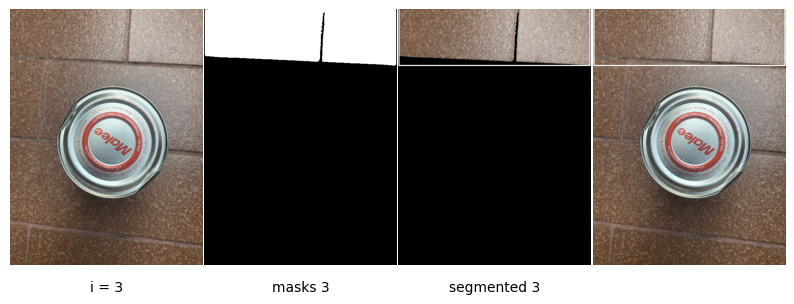

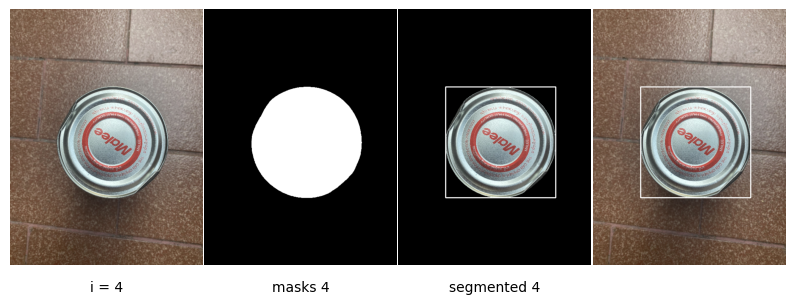

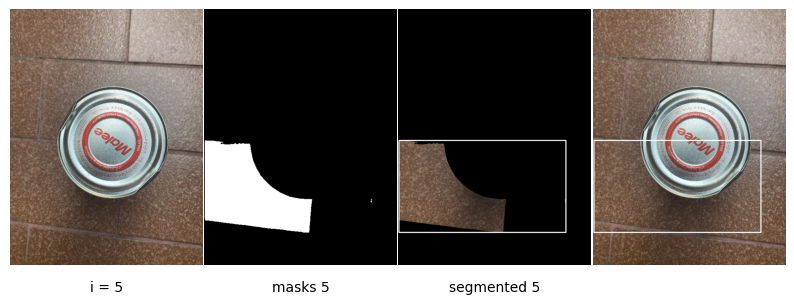

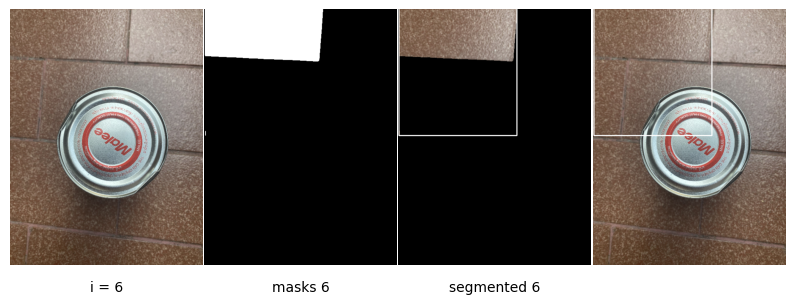

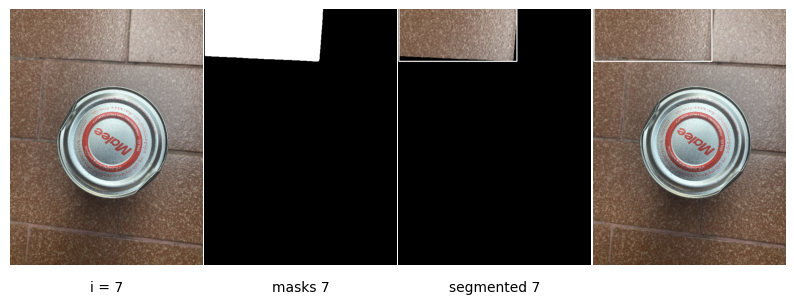

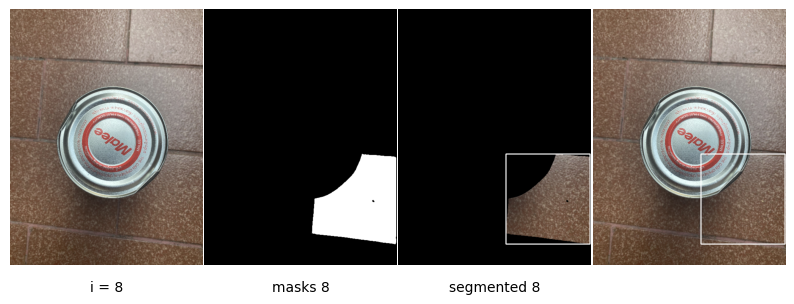

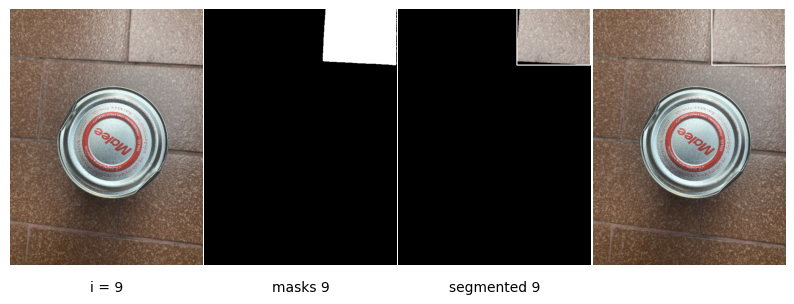

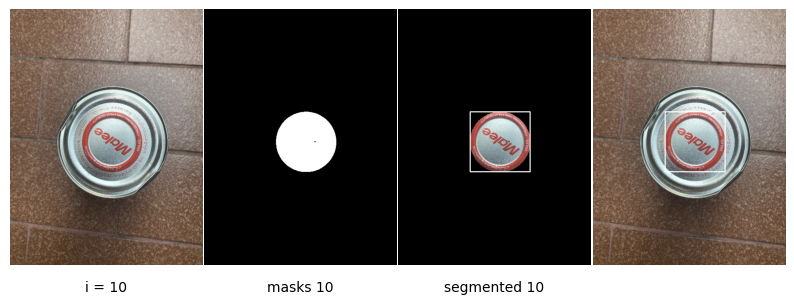

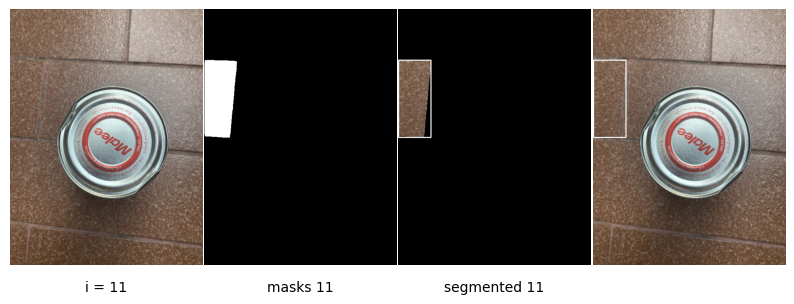

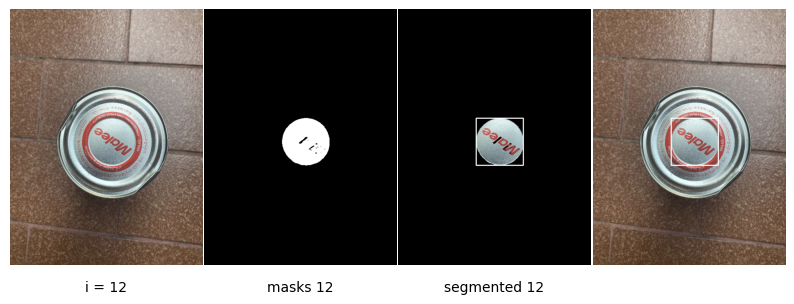

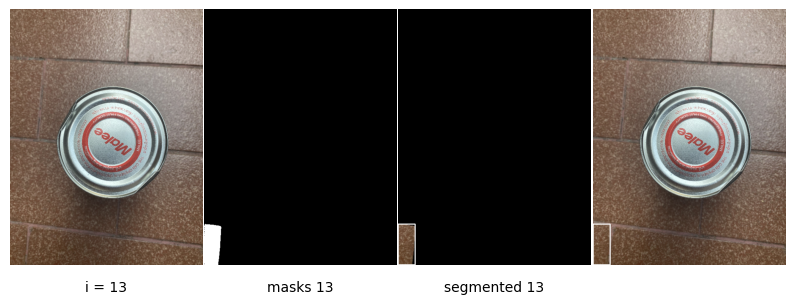

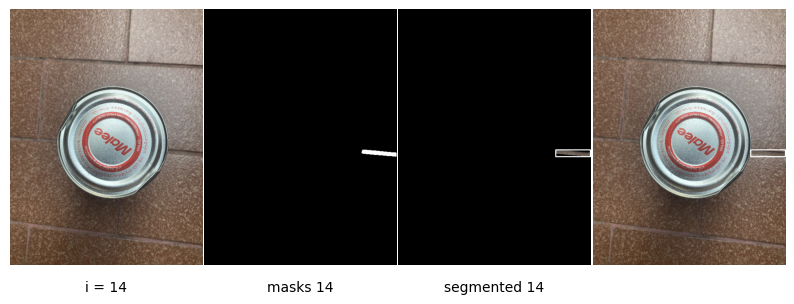

In [161]:
def plot_maskby_index(i) :
    # Create the figure and subplots with no space between them
    fig, axs = plt.subplots(1, 4, figsize=(10,5), gridspec_kw={'wspace': 0.01, 'hspace': 0})

    # Display the images in each subplot with no axis labels
    axs[0].imshow(image_rgb)
    axs[0].axis('off')
    axs[0].text(0.5, -0.1, f'i = {i}', fontsize=10, ha='center', transform=axs[0].transAxes)
    
    axs[1].imshow(masks[i], cmap='gray')
    axs[1].axis('off')
    axs[1].text(0.5, -0.1, f'masks {i}', fontsize=10, ha='center', transform=axs[1].transAxes)
    
    
    #axs[2].imshow(segments[i], cmap='gray')
    axs[2].imshow(cv2.rectangle(segments[i].copy(), (bboxs[i][0], bboxs[i][1]), (bboxs[i][0] + bboxs[i][2], bboxs[i][1] + bboxs[i][3]), (255,255,255), thickness=2))
    axs[2].axis('off')
    axs[2].text(0.5, -0.1, f'segmented {i}', fontsize=10, ha='center', transform=axs[2].transAxes)
    

    axs[3].imshow(cv2.rectangle(image_rgb.copy(), (bboxs[i][0], bboxs[i][1]), (bboxs[i][0] + bboxs[i][2], bboxs[i][1] + bboxs[i][3]), (255,255,255), thickness=2))
    axs[3].axis('off')

    # Show the plot
    plt.show()
    
    
    
for i in range( min(15,len(masks))  ) :
    plot_maskby_index(i)
    

# Full pipe line single image

In [162]:

mask_generator = SamAutomaticMaskGenerator(model=sam,points_per_side=24)


IMAGE_PATH = random.sample(jpg_files, 1)[0] 
image_rgb = GetImage(IMAGE_PATH , new_w = 512)


In [163]:
%time
# Clear CUDA memory
torch.cuda.empty_cache()
sam_result = mask_generator.generate(image_rgb)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.06 µs


In [164]:
masks     = [ mask['segmentation'].astype(np.uint8) * 255 for mask  in sorted(sam_result, key=lambda x: x['area'], reverse=True) ]
bboxs     = [ mask['bbox'] for mask  in sorted(sam_result, key=lambda x: x['area'], reverse=True) ]
segments  =  [ cv2.bitwise_and(image_rgb, image_rgb, mask=img_binary) for img_binary in  masks]



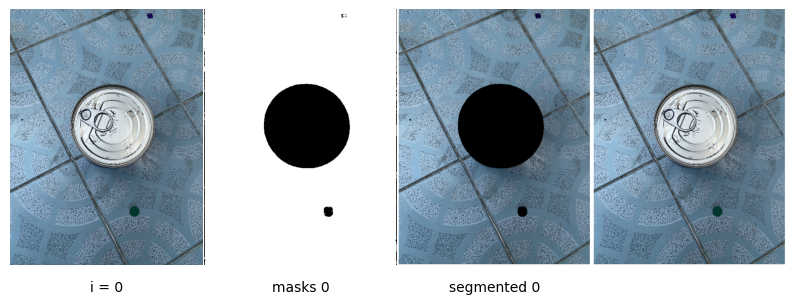

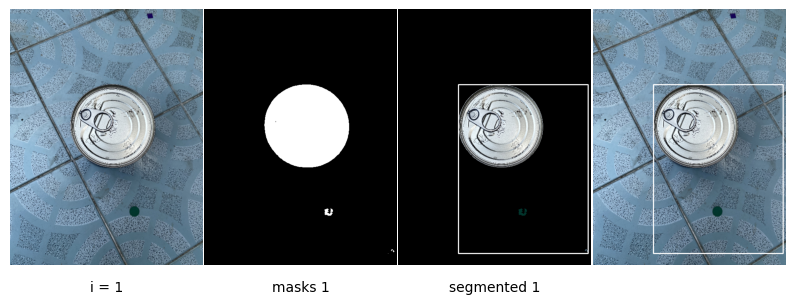

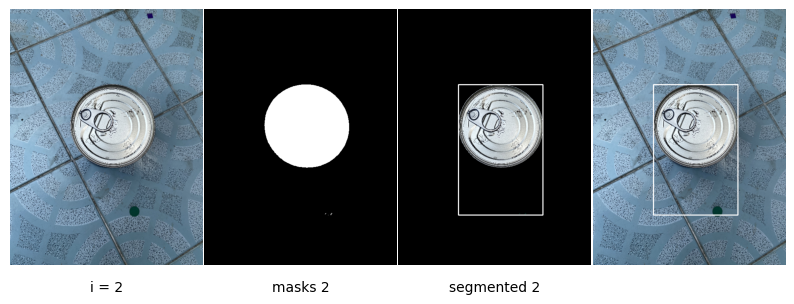

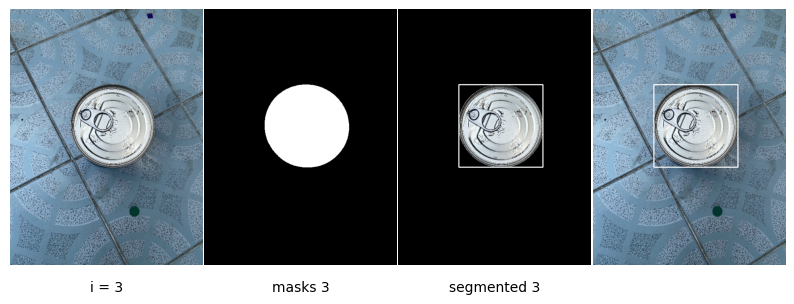

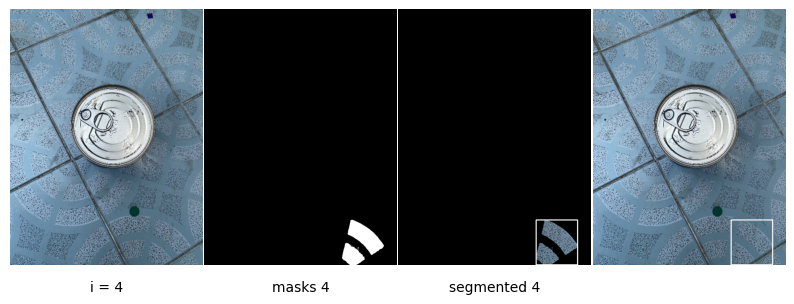

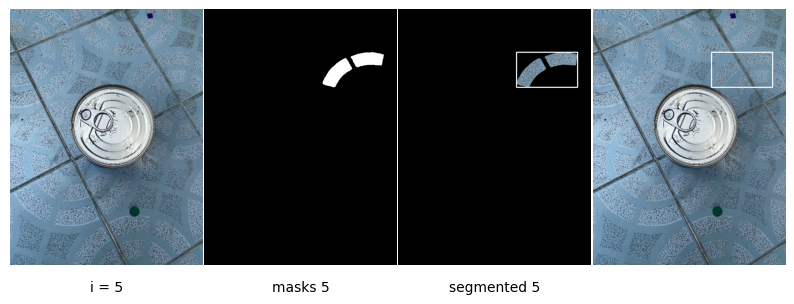

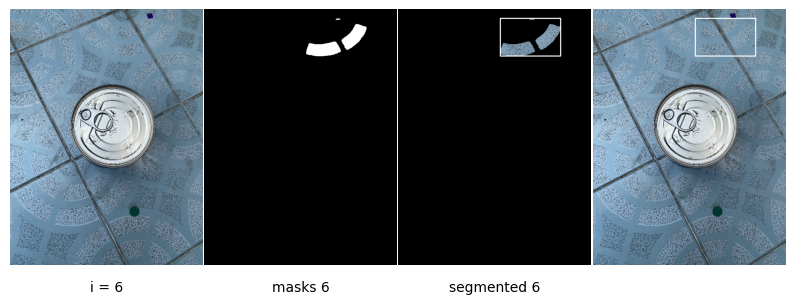

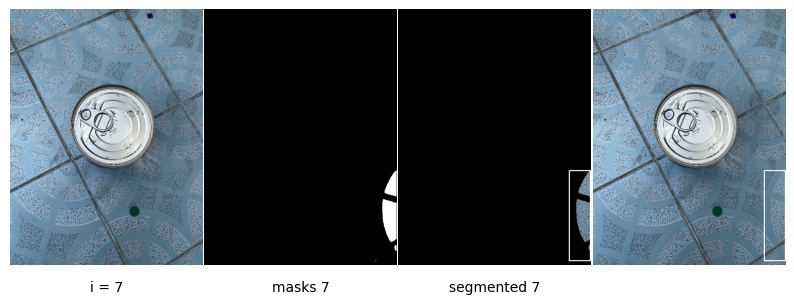

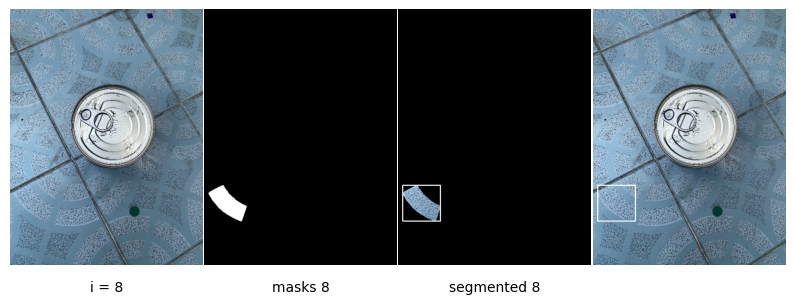

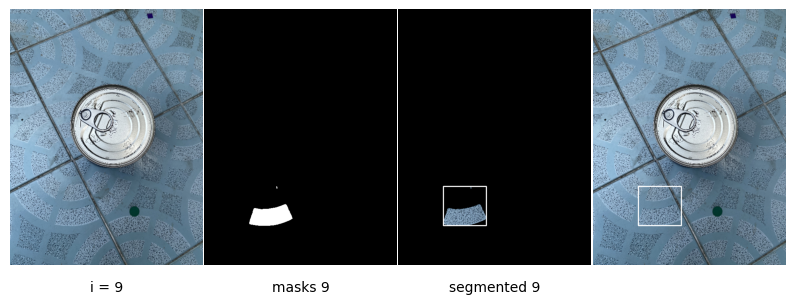

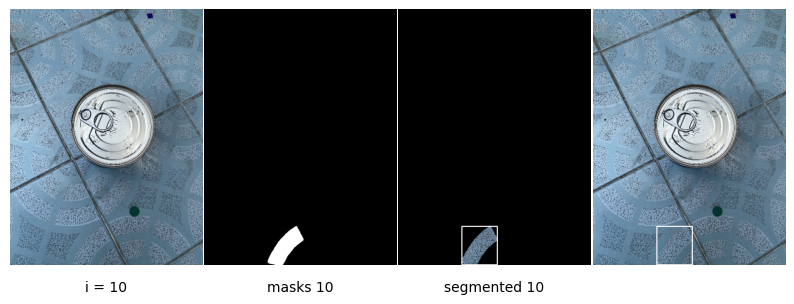

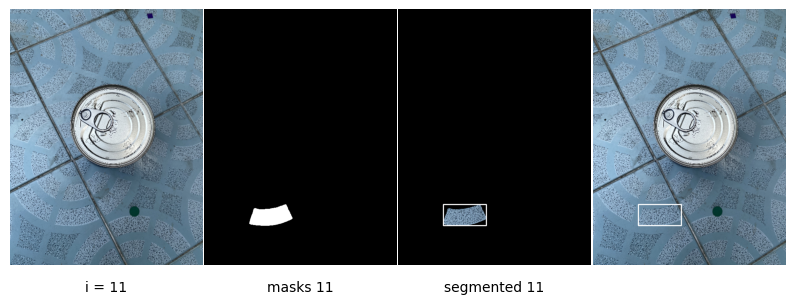

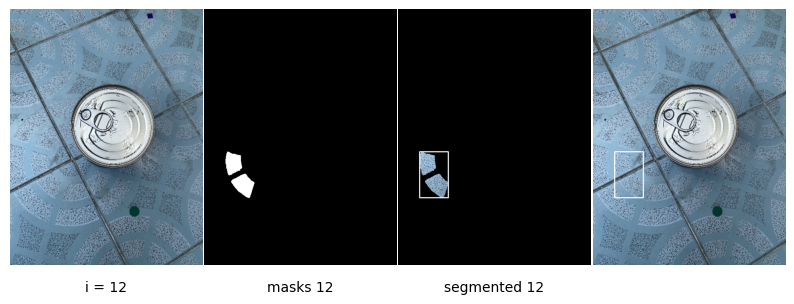

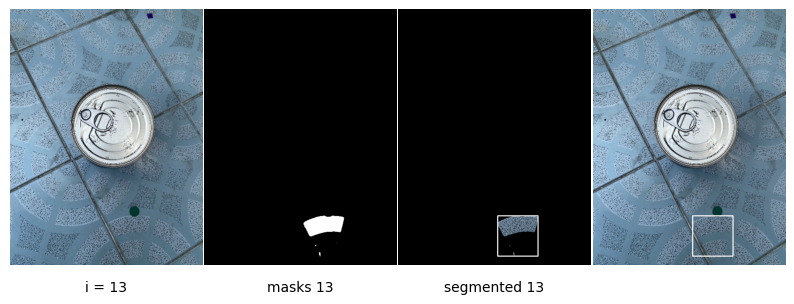

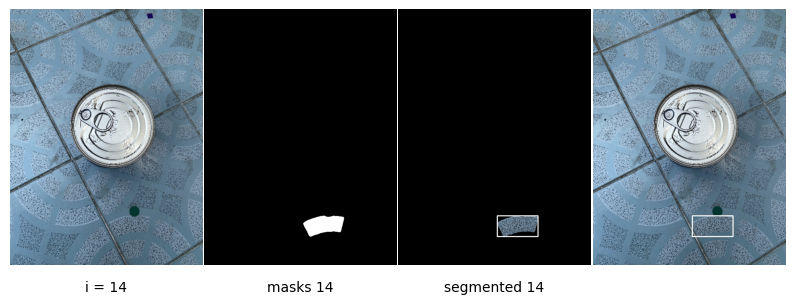

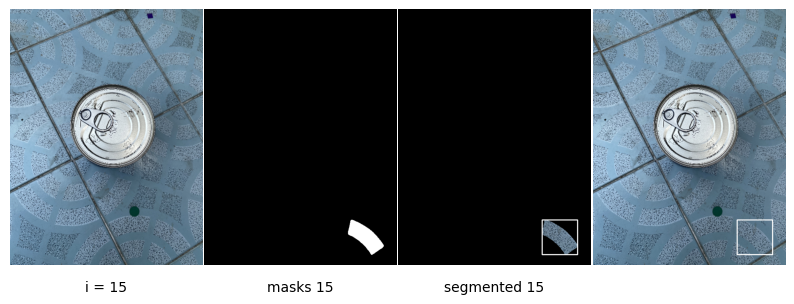

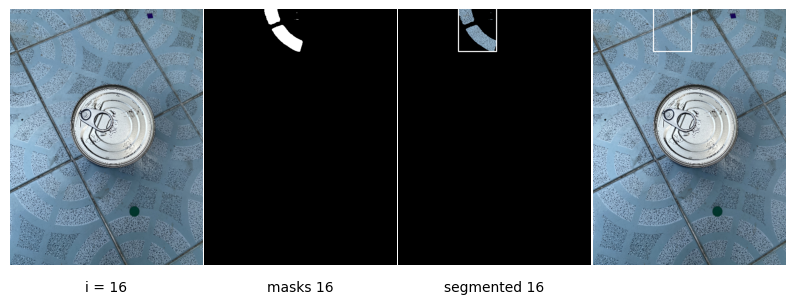

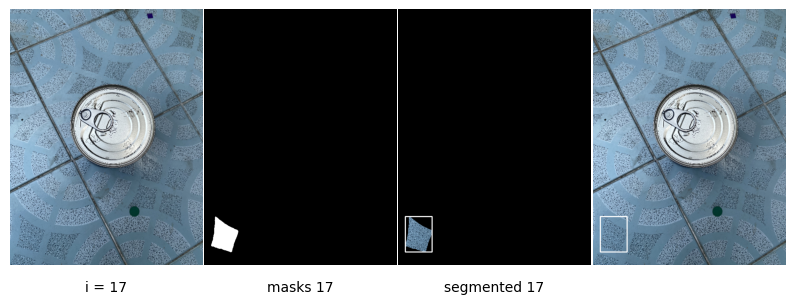

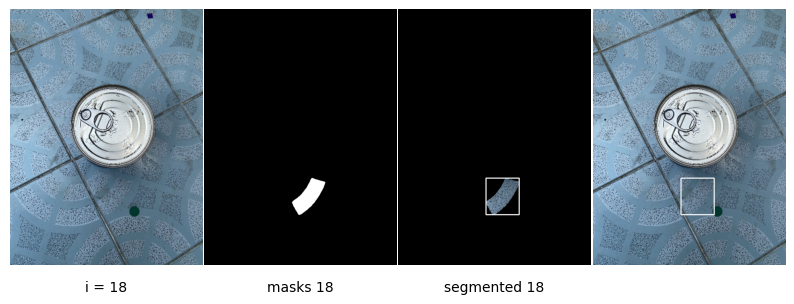

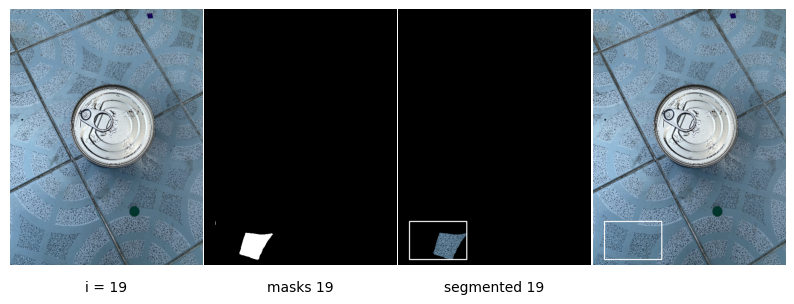

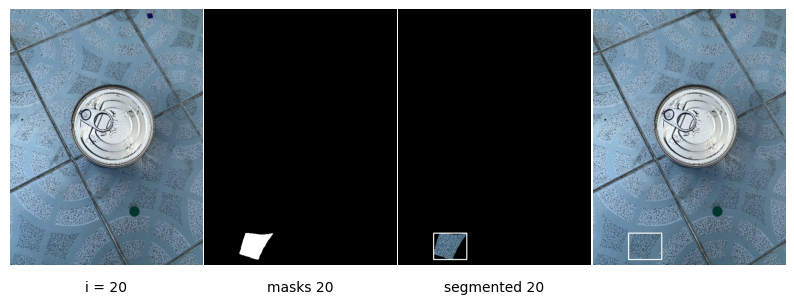

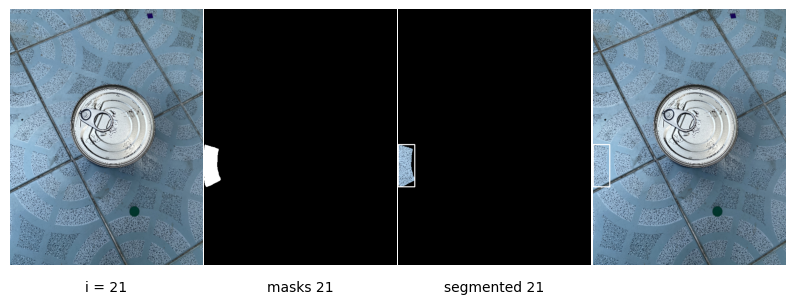

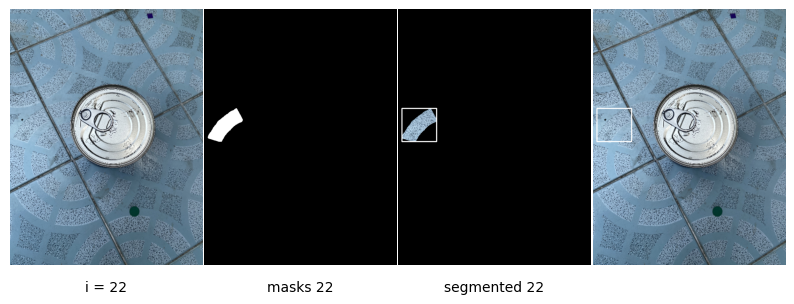

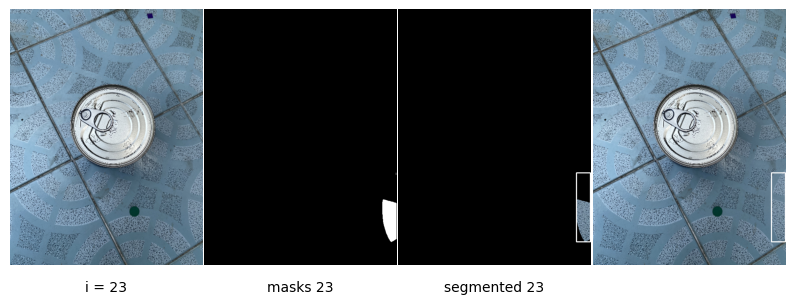

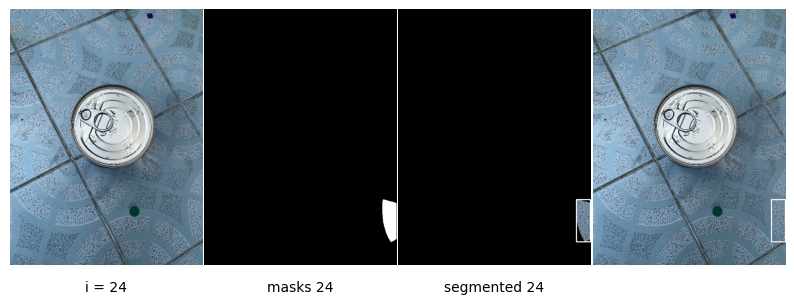

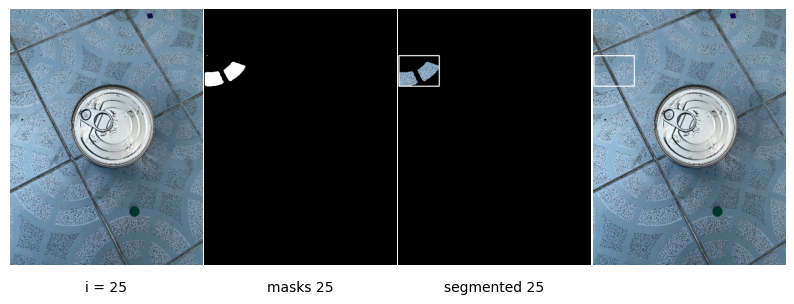

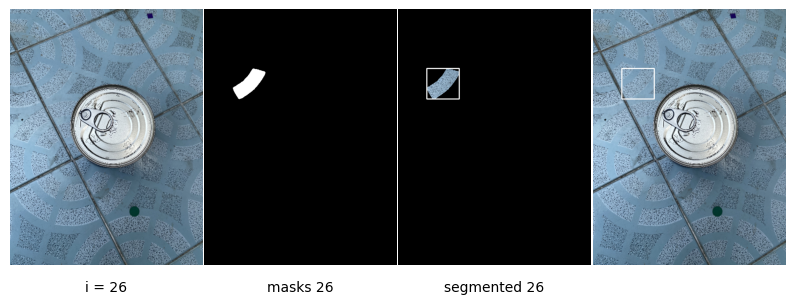

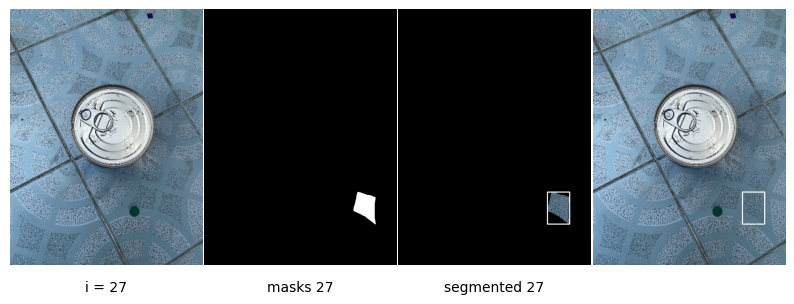

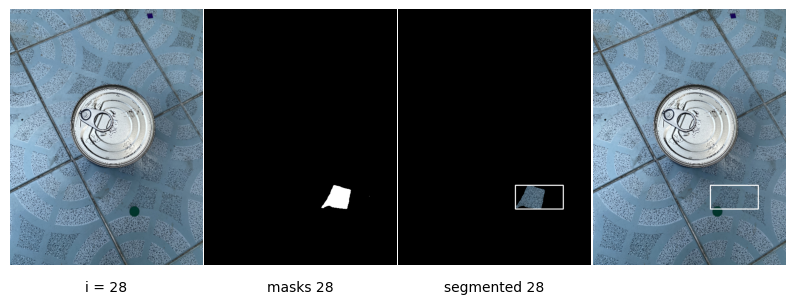

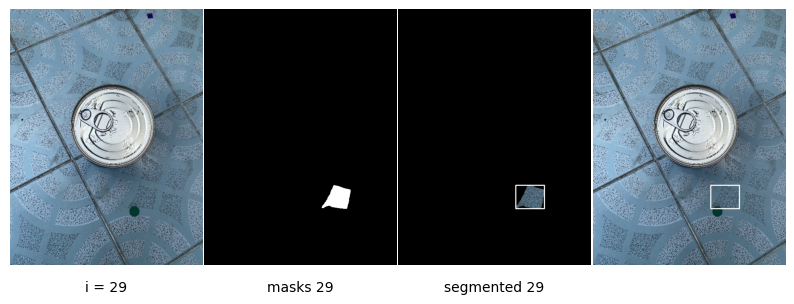

In [165]:
for i in range( min(30,len(masks))  ) :
    plot_maskby_index(i)

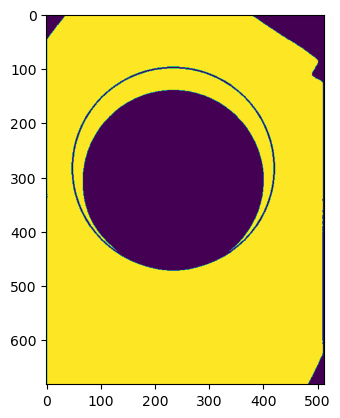

In [166]:


#Apply a blur to the image to reduce noise
img_blur = masks[3].copy()

# Apply the Hough Circle Transform
circles = cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=50, param2=30, minRadius=0, maxRadius=0)

# Draw the circles on the original image
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(img, (x, y), r, (0, 255, 0), 2)
        
plt.imshow(img)        

In [167]:
circles